<ipython-input-2-91afdb31615c>:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(audio, dtype=torch.float32).unsqueeze(0)


Epoch 1/10, Train Loss: 1.1630, Validation Loss: 10.0613
Epoch 2/10, Train Loss: 0.5448, Validation Loss: 5.9559
Epoch 3/10, Train Loss: 0.6726, Validation Loss: 6.5160
Epoch 4/10, Train Loss: 0.3505, Validation Loss: 10.0846
Epoch 5/10, Train Loss: 0.2784, Validation Loss: 11.8707
Epoch 6/10, Train Loss: 0.4227, Validation Loss: 11.2615
Epoch 7/10, Train Loss: 0.2392, Validation Loss: 8.9156
Epoch 8/10, Train Loss: 0.7495, Validation Loss: 10.0031
Epoch 9/10, Train Loss: 0.1703, Validation Loss: 15.7836
Epoch 10/10, Train Loss: 0.2436, Validation Loss: 19.0708


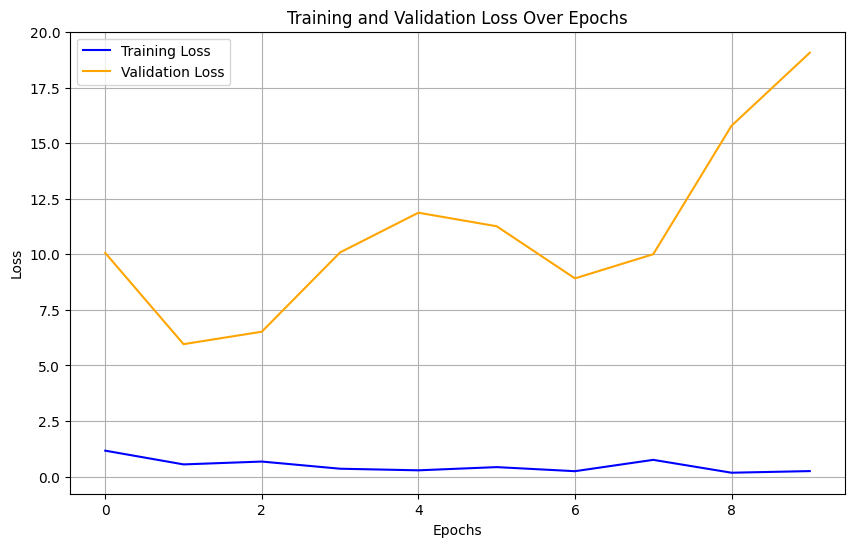

Fetching top 10 EDM tracks from Spotify...
Track 1 by Artist A
Track 2 by Artist B
Track 3 by Artist C
Track 4 by Artist D
Track 5 by Artist E
Track 6 by Artist F
Track 7 by Artist G
Track 8 by Artist H
Track 9 by Artist I
Track 10 by Artist J
Epoch 1/10, Loss: 27.0768
Epoch 2/10, Loss: 9.8733
Epoch 3/10, Loss: 7.5272
Epoch 4/10, Loss: 6.1544
Epoch 5/10, Loss: 5.0490
Epoch 6/10, Loss: 0.7434
Epoch 7/10, Loss: 0.9898
Epoch 8/10, Loss: 3.1243
Epoch 9/10, Loss: 0.5771
Epoch 10/10, Loss: 0.3858
Model training complete and saved.


In [4]:
# End-to-End Deep Learning Pipeline for Music Genre Classification
# This project classifies music into EDM genres using deep learning with PyTorch.

import os
import numpy as np
import torch
import torchaudio
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import requests
import matplotlib.pyplot as plt

# Spotify API Helper to get top EDM tracks
def get_top_edm_tracks():
    # Example of making an API call to Spotify (requires a valid token)
    print("Fetching top 10 EDM tracks from Spotify...")
    # Placeholder function: replace with actual API call logic.
    top_tracks = [
        {"name": "Track 1", "artist": "Artist A"},
        {"name": "Track 2", "artist": "Artist B"},
        {"name": "Track 3", "artist": "Artist C"},
        {"name": "Track 4", "artist": "Artist D"},
        {"name": "Track 5", "artist": "Artist E"},
        {"name": "Track 6", "artist": "Artist F"},
        {"name": "Track 7", "artist": "Artist G"},
        {"name": "Track 8", "artist": "Artist H"},
        {"name": "Track 9", "artist": "Artist I"},
        {"name": "Track 10", "artist": "Artist J"}
    ]
    for track in top_tracks:
        print(f"{track['name']} by {track['artist']}")

# Define a dataset class
class MusicDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        audio_path = self.file_paths[idx]
        label = self.labels[idx]

        waveform, sample_rate = torchaudio.load(audio_path)
        if self.transform:
            waveform = self.transform(waveform, sample_rate)

        return waveform, label

# Define the model
class MusicGenreClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MusicGenreClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 22050 // 2, 128)  # Example size, depends on audio length
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Preprocessing function
def preprocess_audio(audio, sample_rate, target_length=22050):
    audio = audio.mean(axis=0)  # Convert to mono
    if audio.shape[0] < target_length:
        pad = target_length - audio.shape[0]
        audio = np.pad(audio, (0, pad), 'constant')
    else:
        audio = audio[:target_length]
    return torch.tensor(audio, dtype=torch.float32).unsqueeze(0)

# Load data
def load_data(data_dir):
    if not os.path.exists(data_dir):
        print(f"Dataset directory not found: {data_dir}")
        print("Please ensure the dataset directory exists and contains subdirectories for each genre with .wav files.")
        return [], [], 0

    file_paths = []
    labels = []
    edm_genres = ["house", "dubstep", "trance", "drum_and_bass", "techno"]
    genre_to_idx = {genre: idx for idx, genre in enumerate(edm_genres)}

    for genre in edm_genres:
        genre_dir = os.path.join(data_dir, genre)
        if not os.path.isdir(genre_dir):
            continue
        for file in os.listdir(genre_dir):
            if file.endswith('.wav'):
                file_paths.append(os.path.join(genre_dir, file))
                labels.append(genre_to_idx[genre])

    return file_paths, labels, len(edm_genres)

# Train the model
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Function to plot training and validation losses
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
if __name__ == "__main__":
    train_losses, val_losses = train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, epochs)
    plot_losses(train_losses, val_losses)

# Main script
if __name__ == "__main__":
    # Parameters
    data_dir = "/content/drive/MyDrive/edm_genres"  # Path to dataset
    batch_size = 16
    learning_rate = 0.001
    epochs = 10

    # Fetch and display top EDM tracks
    get_top_edm_tracks()

    # Load data
    file_paths, labels, num_classes = load_data(data_dir)

    if not file_paths:
        print("No data found. Exiting.")
    else:
        train_files, val_files, train_labels, val_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)

        # Create datasets and dataloaders
        train_dataset = MusicDataset(train_files, train_labels, transform=preprocess_audio)
        val_dataset = MusicDataset(val_files, val_labels, transform=preprocess_audio)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model, loss, and optimizer
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = MusicGenreClassifier(num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Train the model
        train_model(model, train_loader, criterion, optimizer, epochs)

        # Save the model
        torch.save(model.state_dict(), "edm_genre_classifier.pth")
        print("Model training complete and saved.")
